## Dividir los datos

In [1]:
import os

### Configuración del entorno

In [2]:
os.chdir('..')

In [3]:
os.getcwd()

'c:\\Users\\mrtwe\\TFM\\nnUNet-em'

### Cargar librerías:

In [4]:
from scripts.A_config import NNUNetConfig, DatasetType
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

random.seed(81)
np.random.seed(81)

## Obetener los ficheros

In [11]:
train_images = os.listdir(NNUNetConfig().train_images_dir)
train_ids = sorted({file_name.split(".")[0][:-5] for file_name in train_images})

In [12]:
train_ids

['FIS_001_01',
 'FIS_004_01',
 'FIS_005_01',
 'FIS_006_01',
 'FIS_007_01',
 'FIS_012_01',
 'FIS_013_01',
 'FIS_017_01',
 'FIS_019_01',
 'FIS_028_01',
 'FIS_031_01',
 'FIS_033_01',
 'FIS_041_01',
 'FIS_042_01',
 'FIS_043_01',
 'FIS_044_01',
 'FIS_046_01',
 'FIS_059_01',
 'FIS_061_01',
 'FIS_066_01',
 'FIS_067_01',
 'FIS_068_01',
 'FIS_071_01',
 'FIS_072_01',
 'FIS_075_01',
 'FIS_082_01',
 'FIS_084_01',
 'FIS_086_01',
 'FIS_090_01',
 'FIS_094_01',
 'FIS_099_01',
 'FIS_102_01',
 'FIS_105_01',
 'FIS_107_01',
 'FIS_113_01',
 'FIS_116_01',
 'FIS_117_01',
 'FIS_118_01',
 'FIS_124_01',
 'FIS_127_01',
 'FIS_128_01',
 'REHEM_03_01',
 'REHEM_08_01',
 'REHEM_101_01',
 'REHEM_102_01',
 'REHEM_104_01',
 'REHEM_105_01',
 'REHEM_106_01',
 'REHEM_107_01',
 'REHEM_110_01',
 'REHEM_111_01',
 'REHEM_113_01',
 'REHEM_117_01',
 'REHEM_118_01',
 'REHEM_121_01',
 'REHEM_12_01',
 'REHEM_13_01',
 'REHEM_15_01',
 'REHEM_20_01',
 'REHEM_21_01',
 'REHEM_23_01',
 'REHEM_36_01',
 'REHEM_41_01',
 'REHEM_42_01',
 'REH

In [6]:
len(train_ids)

117

In [7]:
import numpy as np

def flood_fill(label_data, basal_lesions_map, start_coords, lesion_id):
    """Perform a flood fill to label a lesion."""
    stack = [start_coords]
    while stack:
        x, y, z = stack.pop()
        if (0 <= x < label_data.shape[0] and
            0 <= y < label_data.shape[1] and
            0 <= z < label_data.shape[2] and
            label_data[x, y, z] > 0 and
            basal_lesions_map[x, y, z] == 0):
            basal_lesions_map[x, y, z] = lesion_id
            stack.extend([(x+1, y, z), (x-1, y, z), 
                          (x, y+1, z), (x, y-1, z), 
                          (x, y, z+1), (x, y, z-1)])

def detectar_lesiones(label):
    """Detect and label different lesions using a pattern.

    Args:
        label: nifti image with the mask.

    Returns:
        basal_lesions_map: Image with a unique label (int) for each lesion.
        joint_lesions: A dictionary with basal and new lesion identifiers.
    """
    # Convert label data to a numpy array
    label_data = label.get_fdata()

    # Initialize basal lesions map and lesion dictionary
    basal_lesions_map = np.zeros_like(label_data, dtype=int)
    joint_lesions = {'basal': [], 'new': []}

    # Detect lesions and assign unique IDs
    lesion_id = 1
    for coords in np.argwhere(label_data > 0):  # Iterate over all non-zero voxels
        x, y, z = coords
        if basal_lesions_map[x, y, z] == 0:  # If not already labeled
            flood_fill(label_data, basal_lesions_map, (x, y, z), lesion_id)
            joint_lesions['basal'].append(lesion_id)
            lesion_id += 1

    return basal_lesions_map, joint_lesions


In [8]:
import numpy as np
from scipy.ndimage import label as label_regions

def detectar_lesiones(nifti_image):
    """Detect and label different lesions using a pattern.

    Args:
        nifti_image: nifti image object containing the mask.

    Returns:
        basal_lesions_map: Image with a unique label (int) for each lesion.
        joint_lesions: A dictionary with basal and new lesion identifiers.
    """
    # Convert the nifti image data to a numpy array
    label_data = nifti_image.get_fdata()

    # Detect connected components (lesions)
    structure = np.ones((3, 3, 3))  # Define connectivity (26-connectivity)
    basal_lesions_map, num_features = label_regions(label_data > 0, structure=structure)

    # Create a dictionary of lesion IDs
    joint_lesions = {'basal': list(range(1, num_features + 1)), 'new': []}

    return basal_lesions_map, joint_lesions

for case_id in train_ids:
    # obtener la información del label
    label_path = os.path.join(NNUNetConfig().train_labels_dir, case_id + NNUNetConfig().TERMINATION)
    label = nib.load(label_path)
    info_lesiones = detectar_lesiones(label)
    print(info_lesiones)
    break


(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

In [7]:
import numpy as np
from scipy.ndimage import label as label_regions, binary_dilation, center_of_mass

def obtener_estadisticas_lesiones(nifti_image, case_id):
    """
    Detecta lesiones y calcula estadísticas sobre ellas.

    Args:
        nifti_image: Imagen NIfTI que contiene las etiquetas (1=basal, 2=nuevas).
        case_id: Identificador único del caso.

    Returns:
        dict: Diccionario con las estadísticas calculadas.
    """
    
    # Calcular volumen de un voxel
    voxel_volume = np.prod(nifti_image.header.get_zooms())
    
    # Convertir datos a array numpy
    label_data = nifti_image.get_fdata()
    
    # Detectar y etiquetar lesiones basales y nuevas
    basal_map, n_basal = label_regions(label_data == 1)
    new_map, n_new = label_regions(label_data == 2)
    
    # Inicializar listas para volúmenes y relaciones superficie-volumen
    basal_volumes = []
    basal_surface_volume_ratios = []
    basal_centroids = []
    
    for lesion_id in range(1, n_basal + 1):
        lesion_voxels = basal_map == lesion_id
        basal_volumes.append(np.sum(lesion_voxels) * voxel_volume)
        # Calcular superficie
        surface_voxels = np.sum(binary_dilation(lesion_voxels) & ~lesion_voxels)
        basal_surface_volume_ratios.append(surface_voxels / basal_volumes[-1] if basal_volumes[-1] > 0 else 0)
        # Calcular centroide
        basal_centroids.append(center_of_mass(label_data, basal_map, lesion_id))
    
    new_volumes = []
    new_surface_volume_ratios = []
    new_centroids = []
    
    for lesion_id in range(1, n_new + 1):
        lesion_voxels = new_map == lesion_id
        new_volumes.append(np.sum(lesion_voxels) * voxel_volume)
        # Calcular superficie
        surface_voxels = np.sum(binary_dilation(lesion_voxels) & ~lesion_voxels)
        new_surface_volume_ratios.append(surface_voxels / new_volumes[-1] if new_volumes[-1] > 0 else 0)
        # Calcular centroide
        new_centroids.append(center_of_mass(label_data, new_map, lesion_id))
    
    # Calcular estadísticas
    result = {
        "case_id": case_id,
        "n_lesions": n_basal + n_new,
        "n_basal_lesions": n_basal,
        "n_new_lesions": n_new,
        "mean_basal_lesion_vol": np.mean(basal_volumes) if basal_volumes else 0,
        "median_basal_lesion_vol": np.median(basal_volumes) if basal_volumes else 0,
        "std_basal_lesion_vol": np.std(basal_volumes) if basal_volumes else 0,
        "percentile25_basal_lesion_vol": np.percentile(basal_volumes, 25) if basal_volumes else 0,
        "percentile75_basal_lesion_vol": np.percentile(basal_volumes, 75) if basal_volumes else 0,
        "total_basal_lesion_vol": np.sum(basal_volumes),
        "mean_basal_surface_volume_ratio": np.mean(basal_surface_volume_ratios) if basal_surface_volume_ratios else 0,
        "largest_basal_lesion_vol": max(basal_volumes) if basal_volumes else 0,
        "mean_new_lesion_vol": np.mean(new_volumes) if new_volumes else 0,
        "median_new_lesion_vol": np.median(new_volumes) if new_volumes else 0,
        "std_new_lesion_vol": np.std(new_volumes) if new_volumes else 0,
        "percentile25_new_lesion_vol": np.percentile(new_volumes, 25) if new_volumes else 0,
        "percentile75_new_lesion_vol": np.percentile(new_volumes, 75) if new_volumes else 0,
        "total_new_lesion_vol": np.sum(new_volumes),
        "mean_new_surface_volume_ratio": np.mean(new_surface_volume_ratios) if new_surface_volume_ratios else 0,
        "largest_new_lesion_vol": max(new_volumes) if new_volumes else 0,
        "ratio_basal_new_lesions": (n_basal / n_new) if n_new > 0 else np.inf,
        "basal_centroids": basal_centroids,
        "new_centroids": new_centroids,
    }
    
    return result

In [9]:


resultados = []
for case_id in train_ids:
    # Obtener la información del label
    label_path = os.path.join(NNUNetConfig().train_labels_dir, case_id + NNUNetConfig().TERMINATION)
    label = nib.load(label_path)
    info_lesiones = obtener_estadisticas_lesiones(label, case_id)
    resultados.append(info_lesiones)


In [10]:
resultados[0]

{'case_id': 'FIS_001_01',
 'n_lesions': 37,
 'n_basal_lesions': 37,
 'n_new_lesions': 0,
 'mean_basal_lesion_vol': 90.0,
 'median_basal_lesion_vol': 45.0,
 'std_basal_lesion_vol': 105.15059984920984,
 'percentile25_basal_lesion_vol': 22.0,
 'percentile75_basal_lesion_vol': 139.0,
 'total_basal_lesion_vol': 3330.0,
 'mean_basal_surface_volume_ratio': 2.2676875301238995,
 'largest_basal_lesion_vol': 456.0,
 'mean_new_lesion_vol': 0,
 'median_new_lesion_vol': 0,
 'std_new_lesion_vol': 0,
 'percentile25_new_lesion_vol': 0,
 'percentile75_new_lesion_vol': 0,
 'total_new_lesion_vol': 0.0,
 'mean_new_surface_volume_ratio': 0,
 'largest_new_lesion_vol': 0,
 'ratio_basal_new_lesions': inf,
 'basal_centroids': [(41.63333333333333,
   126.16666666666667,
   108.03333333333333),
  (53.84, 83.408, 71.86666666666666),
  (52.94930875576037, 109.95391705069125, 58.9815668202765),
  (54.57142857142857, 81.52380952380952, 82.76190476190476),
  (57.357142857142854, 91.53571428571429, 80.10714285714286),


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Convertir resultados a un DataFrame
lesions_analysis = pd.DataFrame(resultados)

# Estratificación inicial
# 1. Discretizar n_basal_lesions y n_new_lesions
lesions_analysis['bl_bin'] = pd.qcut(lesions_analysis['n_basal_lesions'], q=3, duplicates='drop')  # Por cuantiles
lesions_analysis['nl_bin'] = pd.cut(  # Por rangos personalizados
    lesions_analysis['n_new_lesions'], 
    bins=[0, 1, 5, np.inf], 
    right=False
)

# 2. Discretizar total_basal_lesion_vol y total_new_lesion_vol
lesions_analysis['total_basal_vol_bin'] = pd.qcut(lesions_analysis['total_basal_lesion_vol'], q=3, duplicates='drop')
lesions_analysis['total_new_vol_bin'] = pd.cut(
    lesions_analysis['total_new_lesion_vol'], 
    bins=[0, 10, 50, np.inf], 
    right=False
)

# 3. Crear una clase combinada para estratificación
lesions_analysis['stratification_bin'] = (
    lesions_analysis['bl_bin'].astype(str) + ' & ' +
    lesions_analysis['nl_bin'].astype(str) + ' & ' +
    lesions_analysis['total_basal_vol_bin'].astype(str) + ' & ' +
    lesions_analysis['total_new_vol_bin'].astype(str)
)

# 4. Factorizar la clase combinada
lesions_analysis['stratification_class'] = pd.factorize(lesions_analysis['stratification_bin'])[0]

# Manejo de clases raras
# Contar las frecuencias de cada clase
class_counts = lesions_analysis['stratification_class'].value_counts()

# Definir un umbral mínimo (clases con menos de 2 muestras se agrupan)
threshold = 2
rare_classes = class_counts[class_counts < threshold].index

# Reemplazar las clases raras por una categoría común
lesions_analysis.loc[
    lesions_analysis['stratification_class'].isin(rare_classes), 
    'stratification_class'
] = -1  # Categoría para clases raras

# Volver a verificar las clases después del agrupamiento
lesions_analysis['stratification_class'] = pd.factorize(lesions_analysis['stratification_class'])[0]

# División en Train y Test (estratificada)
train_val_ids, test_ids = train_test_split(
    lesions_analysis['case_id'], 
    test_size=0.3, 
    stratify=lesions_analysis['stratification_class']
)

# Verificar balance de clases en Train y Test
train_classes = lesions_analysis.loc[lesions_analysis['case_id'].isin(train_val_ids), 'stratification_class']
test_classes = lesions_analysis.loc[lesions_analysis['case_id'].isin(test_ids), 'stratification_class']

print(f"Distribución en Train:\n{train_classes.value_counts(normalize=True)}")
print(f"Distribución en Test:\n{test_classes.value_counts(normalize=True)}")


Distribución en Train:
stratification_class
0     0.135802
10    0.111111
3     0.074074
7     0.074074
8     0.074074
11    0.074074
19    0.074074
9     0.074074
5     0.061728
4     0.049383
15    0.049383
6     0.024691
2     0.024691
16    0.024691
12    0.012346
17    0.012346
14    0.012346
13    0.012346
1     0.012346
18    0.012346
Name: proportion, dtype: float64
Distribución en Test:
stratification_class
0     0.138889
10    0.111111
9     0.083333
8     0.083333
7     0.055556
11    0.055556
19    0.055556
3     0.055556
5     0.055556
6     0.027778
17    0.027778
1     0.027778
4     0.027778
14    0.027778
18    0.027778
15    0.027778
2     0.027778
12    0.027778
16    0.027778
13    0.027778
Name: proportion, dtype: float64


In [12]:
len(train_val_ids), len(test_ids)

(81, 36)

In [13]:
try:
    os.mkdir(NNUNetConfig().test_images_dir)
except FileExistsError:
    pass
try:
    os.mkdir(NNUNetConfig().test_labels_dir)
except FileExistsError:
    pass

In [14]:
import shutil

for case_id in test_ids:
    # Mover imágenes de test a la carpeta correspondiente, basal, follow-up y label
    basal_image_path = os.path.join(NNUNetConfig().train_images_dir, case_id + "_0000" + NNUNetConfig().TERMINATION)
    follow_up_image_path = os.path.join(NNUNetConfig().train_images_dir, case_id + "_0001" + NNUNetConfig().TERMINATION) 
    label_path = os.path.join(NNUNetConfig().train_labels_dir, case_id + NNUNetConfig().TERMINATION)
    
    shutil.move(basal_image_path, os.path.join(NNUNetConfig().test_images_dir, os.path.basename(basal_image_path)))
    shutil.move(follow_up_image_path, os.path.join(NNUNetConfig().test_images_dir, os.path.basename(follow_up_image_path)))
    shutil.move(label_path, os.path.join(NNUNetConfig().test_labels_dir, os.path.basename(label_path)))

In [15]:
from sklearn.model_selection import StratifiedKFold
import json

# Preparar los datos para StratifiedKFold
train_stratification_bins = lesions_analysis.loc[
    lesions_analysis['case_id'].isin(train_val_ids),
    'stratification_class'
]
train_case_ids = lesions_analysis.loc[
    lesions_analysis['case_id'].isin(train_val_ids),
    'case_id'
]

# Inicializar StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Generar pliegues y guardar en lista
cv_folds = []
for train_idx, val_idx in skf.split(X=train_case_ids, y=train_stratification_bins):
    fold = {
        "train": train_case_ids.iloc[train_idx].tolist(),
        "val": train_case_ids.iloc[val_idx].tolist()
    }
    cv_folds.append(fold)

# Guardar los pliegues en un archivo JSON
#if is windows os
if os.name == 'nt':
    with open(NNUNetConfig().dataset_preprocessed_dir / "splits_final.json", "w") as f:
        json.dump(cv_folds, f)
else:
    with open(NNUNetConfig().dataset_preprocessed_dir() / "splits_final.json", "w") as f:
        json.dump(cv_folds, f)


print(f"Se han generado {n_splits} pliegues para validación cruzada.")


Se han generado 5 pliegues para validación cruzada.


c:\Users\mrtwe\miniforge3\envs\TFM\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Análisis cuantitativo de los datos

In [13]:
import json
train_images = os.listdir(NNUNetConfig().train_images_dir)
train_ids = sorted({file_name.split(".")[0][:-5] for file_name in train_images})

test_images = os.listdir(NNUNetConfig().test_images_dir)
test_ids = sorted({file_name.split(".")[0][:-5] for file_name in test_images})

split_file = os.path.join(NNUNetConfig().dataset_preprocessed_dir, "splits_final.json")
splits = json.load(open(split_file))

In [8]:
train_analisis = []
for case_id in train_ids:
    # Obtener la información del label
    label_path = os.path.join(NNUNetConfig().train_labels_dir, case_id + NNUNetConfig().TERMINATION)
    label = nib.load(label_path)
    info_lesiones = obtener_estadisticas_lesiones(label, case_id)
    train_analisis.append(info_lesiones)

In [15]:
test_analisis = []
for case_id in test_ids:
    # Obtener la información del label
    label_path = os.path.join(NNUNetConfig().test_labels_dir, case_id + NNUNetConfig().TERMINATION)
    label = nib.load(label_path)
    info_lesiones = obtener_estadisticas_lesiones(label, case_id)
    test_analisis.append(info_lesiones)

In [53]:
lesions_analysis_train = pd.DataFrame(train_analisis)
lesions_analysis_test = pd.DataFrame(test_analisis)

import pandas as pd

# Supongamos que ya tienes los DataFrames `lesions_analysis_train` y `lesions_analysis_test`
lesions_analysis_train = pd.DataFrame(train_analisis)
lesions_analysis_test = pd.DataFrame(test_analisis)

# Selecciona las columnas no numéricas
non_numeric_columns_train = lesions_analysis_train.select_dtypes(exclude=['number']).columns
non_numeric_columns_train = non_numeric_columns_train[non_numeric_columns_train != 'case_id']
non_numeric_columns_test = lesions_analysis_test.select_dtypes(exclude=['number']).columns
non_numeric_columns_test = non_numeric_columns_test[non_numeric_columns_test != 'case_id']

# Extrae las columnas no numéricas en nuevos DataFrames
non_numeric_train = lesions_analysis_train[non_numeric_columns_train]
non_numeric_test = lesions_analysis_test[non_numeric_columns_test]

# Muestra las columnas no numéricas
print("Columnas no numéricas en el conjunto de entrenamiento:")
print(non_numeric_columns_train)

print("Columnas no numéricas en el conjunto de prueba:")
print(non_numeric_columns_test)



Columnas no numéricas en el conjunto de entrenamiento:
Index(['basal_centroids', 'new_centroids'], dtype='object')
Columnas no numéricas en el conjunto de prueba:
Index(['basal_centroids', 'new_centroids'], dtype='object')


In [54]:
train_non_avg_cols = lesions_analysis_train.columns[lesions_analysis_train.columns.str.contains('mean') | lesions_analysis_train.columns.str.contains('median')].tolist()

test_non_avg_cols = lesions_analysis_test.columns[lesions_analysis_test.columns.str.contains('mean') | lesions_analysis_test.columns.str.contains('median')].tolist()

In [55]:
lesions_analysis_train = lesions_analysis_train.drop(columns=train_non_avg_cols)
lesions_analysis_test = lesions_analysis_test.drop(columns=test_non_avg_cols)

lesions_analysis_train = lesions_analysis_train.drop(columns=non_numeric_columns_train)
lesions_analysis_test = lesions_analysis_test.drop(columns=non_numeric_columns_test)

In [56]:
lesions_analysis_train

,case_id,n_lesions,n_basal_lesions,n_new_lesions,std_basal_lesion_vol,percentile25_basal_lesion_vol,percentile75_basal_lesion_vol,total_basal_lesion_vol,largest_basal_lesion_vol,std_new_lesion_vol,percentile25_new_lesion_vol,percentile75_new_lesion_vol,total_new_lesion_vol,largest_new_lesion_vol,ratio_basal_new_lesions
0,FIS_001_01,37,37,0,105.150600,22.00,139.00,3330.0,456.0,0.000000,0.0,0.0,0.0,0.0,inf
1,FIS_004_01,152,148,4,1565.736362,4.75,35.00,31792.0,14559.0,43.413708,35.0,70.5,254.0,138.0,37.000000
2,FIS_005_01,53,44,9,43.965867,9.75,68.75,1819.0,195.0,66.213646,25.0,46.0,491.0,235.0,4.888889
3,FIS_006_01,99,99,0,164.230780,6.00,69.00,7498.0,1024.0,0.000000,0.0,0.0,0.0,0.0,inf
4,FIS_007_01,35,35,0,222.593874,8.50,257.00,5310.0,870.0,0.000000,0.0,0.0,0.0,0.0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,REHEM_86_01,82,82,0,41.875527,18.00,55.75,3738.0,242.0,0.000000,0.0,0.0,0.0,0.0,inf
77,REHEM_87_01,75,75,0,187.587384,33.00,165.00,9449.0,1318.0,0.000000,0.0,0.0,0.0,0.0,inf
78,REHEM_88_01,56,56,0,67.285105,27.00,63.00,3373.0,411.0,0.000000,0.0,0.0,0.0,0.0,inf
79,REHEM_97_01,49,49,0,42.366718,26.00,58.00,2513.0,237.0,0.000000,0.0,0.0,0.0,0.0,inf


In [57]:
lesions_analysis_train['val_fold'] = lesions_analysis_train['case_id'].apply(lambda x: [i for i, fold in enumerate(splits) if x in fold['val']][0])

print(lesions_analysis_train['val_fold'].value_counts())

val_fold
0    17
2    16
1    16
3    16
4    16
Name: count, dtype: int64


In [64]:
fold_stats = lesions_analysis_train.drop(columns=['case_id']).groupby('val_fold').mean()

basal_sums = fold_stats.filter(like='basal').groupby('val_fold').sum()

fold_stats['mean_basal_lesion_vol'] = basal_sums['total_basal_lesion_vol'] / basal_sums['n_basal_lesions']

new_sums = fold_stats.filter(like='new').groupby('val_fold').sum()

fold_stats['mean_new_lesion_vol'] = new_sums['total_new_lesion_vol'] / new_sums['n_new_lesions']


In [65]:
dataframe = pd.concat([lesions_analysis_train, lesions_analysis_test], axis=0)

<Axes: >

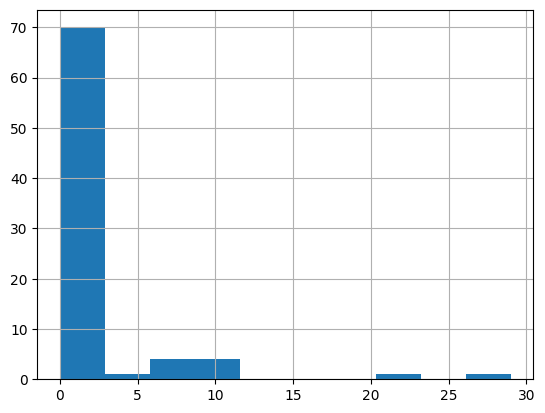

In [67]:
lesions_analysis_train.n_new_lesions.hist()

<Axes: >

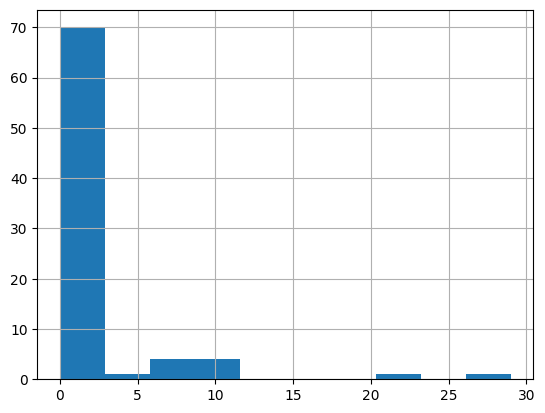

In [68]:
dataframe.dropna().n_new_lesions.hist()

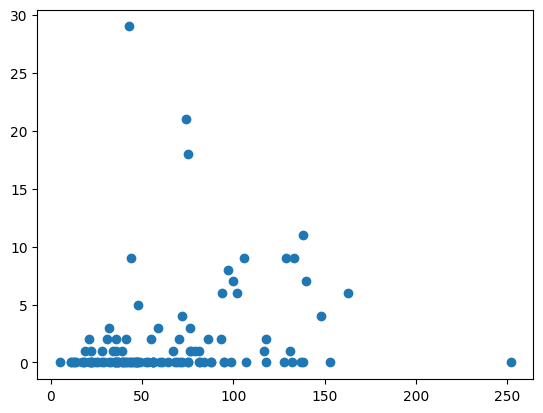

In [70]:
plt.scatter(dataframe.n_basal_lesions, dataframe.n_new_lesions)

In [71]:
from scipy.stats import pearsonr
pearsonr(dataframe.n_basal_lesions, dataframe.n_new_lesions).statistic

0.21100259203650268

In [72]:
dataframe

,case_id,n_lesions,n_basal_lesions,n_new_lesions,std_basal_lesion_vol,percentile25_basal_lesion_vol,percentile75_basal_lesion_vol,...,std_new_lesion_vol,percentile25_new_lesion_vol,percentile75_new_lesion_vol,total_new_lesion_vol,largest_new_lesion_vol,ratio_basal_new_lesions,val_fold
0,FIS_001_01,37,37,0,105.150600,22.00,139.00,...,0.000000,0.0,0.0,0.0,0.0,inf,2.0
1,FIS_004_01,152,148,4,1565.736362,4.75,35.00,...,43.413708,35.0,70.5,254.0,138.0,37.000000,1.0
2,FIS_005_01,53,44,9,43.965867,9.75,68.75,...,66.213646,25.0,46.0,491.0,235.0,4.888889,2.0
3,FIS_006_01,99,99,0,164.230780,6.00,69.00,...,0.000000,0.0,0.0,0.0,0.0,inf,0.0
4,FIS_007_01,35,35,0,222.593874,8.50,257.00,...,0.000000,0.0,0.0,0.0,0.0,inf,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,REHEM_63_01,132,131,1,1902.625630,22.50,58.50,...,0.000000,20.0,20.0,20.0,20.0,131.000000,NaN
32,REHEM_70_01,29,28,1,812.041276,36.75,93.25,...,0.000000,4.0,4.0,4.0,4.0,28.000000,NaN
33,REHEM_80_01,11,11,0,77.622630,65.50,152.00,...,0.000000,0.0,0.0,0.0,0.0,inf,NaN
34,REHEM_81_01,60,60,0,170.753633,26.00,111.75,...,0.000000,0.0,0.0,0.0,0.0,inf,NaN
